In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers
!pip install torch
!pip install tensorflow

In [7]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import unicodedata
import string
import re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
import numpy as np
import pickle
import nltk
from nltk.corpus import stopwords

In [4]:
#loading, inspecting, cleaning dataset

df_dataset = pd.read_csv('/content/drive/MyDrive/combined_final_dataset.csv')
df_dataset = df_dataset[['text', 'label']] #making sure we have the correct columns
df_dataset['label'] = df_dataset['label'].astype(int)

nltk.download('stopwords')

# create a function to clean Greek text
def clean_text(text):
  #convert the text to lowercase
  text = text.lower()

  #remove stopwords
  stop_words = set(stopwords.words('greek'))
  words = text.split()
  words = [word for word in words if word not in stop_words]
  text = ' '.join(words)

  # remove all diacritics from modern and ancient Greek by normalizing and deleting nonspacing marks : took advice from the documentation https://unicode.org/reports/tr15/
  text = ''.join(
      c for c in unicodedata.normalize('NFD', text)
      if unicodedata.category(c) != 'Mn'
  )

  # remove extra whitespace
  text = re.sub(r'\s+', ' ', text).strip()

  return text

# apply the function to the 'text' column of the dataframe
df_dataset['text'] = df_dataset['text'].astype(str).apply(clean_text)
print(df_dataset)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                                                   text  label
0     ζελενσκι: ενταξη νατο ειρηνευτικες διαπραγματε...      0
1     καμια ξενη δυναμη βρισκεται ελληνικο εδαφος, κ...      0
2     ετοιμοι διαφυγουν εξωτερικο ζελενσκι βουλευτες...      1
3     …μας εστειλε ενας φιλος… ενας ανθρωπος δυστυχω...      1
4     οδοιπορικο ενα απομακρυσμενο πολλους αγνωστο ε...      1
...                                                 ...    ...
1995  επιστολη υφυπουργος αθλητισμου, λευτερης αυγεν...      0
1996  o παοκ πηρε πολυτιμη οσο δυσκολη νικη ηρακλειο...      0
1997  δειτε ολες τελευταιες ειδησεις απο ελλαδα κοσμ...      0
1998  εντονες αντιδρασεις εχει προκαλεσει γεγονος οτ...      1
1999  αξιοποιηση δημοφιλη τραγουδιστη γιαννη φλωρινι...      1

[2000 rows x 2 columns]


In [5]:
#stratified train-test split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_dataset['text'], df_dataset['label'], test_size=0.2, stratify=df_dataset['label'], random_state=9
)

#loading multilingual MiniLM model (sentence transformers)
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

#text encoding via sentence transformers
train_embeddings = model.encode(train_texts.tolist(), batch_size=32, show_progress_bar=True)
test_embeddings = model.encode(test_texts.tolist(), batch_size=32, show_progress_bar=True)

#text encoding via TF-IDF
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,2))
train_tfidf = tfidf.fit_transform(train_texts)
test_tfidf = tfidf.transform(test_texts)

#combining the two
train_combined = hstack([train_tfidf, csr_matrix(train_embeddings)])
test_combined  = hstack([test_tfidf,  csr_matrix(test_embeddings)])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/50 [00:00<?, ?it/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Accuracy: 0.825
Classification report:
               precision    recall  f1-score   support

   Real news       0.84      0.81      0.82       200
   Fake news       0.81      0.84      0.83       200

    accuracy                           0.82       400
   macro avg       0.83      0.82      0.82       400
weighted avg       0.83      0.82      0.82       400



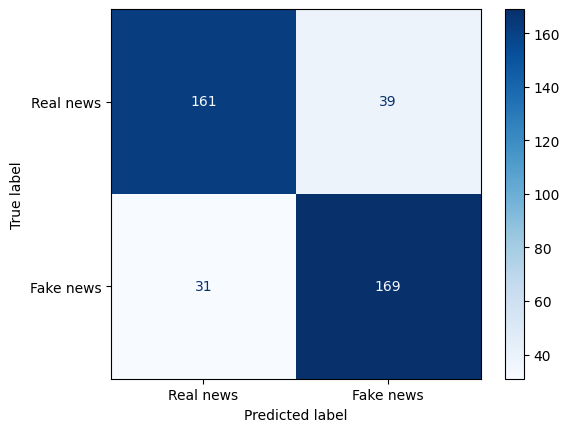

In [10]:
#training a logistic regression model
clf = LogisticRegression(max_iter=1000, class_weight='balanced', solver='saga')
clf.fit(train_combined, train_labels)

# predictions on test set
preds = clf.predict(test_combined)

print(f'Accuracy: {accuracy_score(test_labels, preds)}')

print(f"Classification report:\n {classification_report(test_labels, preds, target_names=['Real news', 'Fake news'])}")

# Confusion matrix
cm = confusion_matrix(test_labels, preds)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real news', 'Fake news'])
display.plot(cmap="Blues")

In [11]:
#save model for later use
with open('fake_news_model.pkl', 'wb') as f:
  pickle.dump((clf), f)

print('Model saved to fake_news_model.pkl')

Model saved to fake_news_model.pkl


# Part: Explainable AI (XAI) | Explainable Predictions with SHAP & Case-Based Reasoning (CBR)
This section contains human-readable explanations to our fake-news classifier. First, we use SHAP to identify the specific tokens that support the model’s final prediction (Real or Fake) for each article, along with their contribution strengths. Second, we provide case-based reasoning (CBR) by retrieving the most similar training articles (via cosine similarity on MiniLM embeddings) and presenting their ground-truth labels and the model’s predicted probabilities. Together, these views explain "which words mattered" and "which past cases it resembles", improving trust, debugging and reporting without changing the core model.

In [ ]:
# install/upgrade the SHAP library
!pip install -q -U shap
import shap # library for explaining the predictions of machine learning models

In [ ]:
# Wrapper: from raw text : [P(Real), P(Fake)] following the exact same pipeline as in training
def predict_proba_from_text(text_list):
  cleaned = [clean_text(t) for t in text_list] # clean each text using the same preprocessing function as during training
  X_tfidf = tfidf.transform(cleaned) # convert cleaned text into TF-IDF features (sparse matrix)
  X_emb = model.encode(cleaned, show_progress_bar=False) # generate sentence embeddings from the pre-trained embedding model
  X_comb = hstack([X_tfidf, csr_matrix(np.asarray(X_emb))]) # combine TF-IDF and embeddings
  return clf.predict_proba(X_comb) # predict probabilities for each class [P(Real), P(Fake)] using the trained classifier

In [ ]:
# Create a SHAP Text masker, which breaks the input text into tokens so SHAP can test the impact of each word on the prediction.
# If the standard API call fails, fall back to importing Text directly from shap.maskers
try:
  masker = shap.maskers.Text()
except Exception:
  from shap.maskers import Text
  masker = Text()

# create a SHAP Explainer using our text: probability function documentation: https://shap.readthedocs.io/en/latest/generated/shap.Explainer.html
shap_expl = shap.Explainer(predict_proba_from_text, masker, seed=9)

label_names = {0: "Real", 1: "Fake"}

# we use this function for finding the tokens that push the model towards its final prediction
def shap_support_tokens(text, top_k=10):
  probs = predict_proba_from_text([text])[0]          # get prediction probabilities [P(Real), P(Fake)]
  pred_class = int(np.argmax(probs))                    # index of the class with highest category probability
  pred_name = label_names[pred_class]                    # name of this class

# run SHAP on the text
  sv = shap_expl([text])
  tokens = sv[0].data                            # the tokens as seen by SHAP
  vals = sv[0].values[:, pred_class]             # SHAP values for the predicted class

  # keep only tokens with positive contribution
  pos_idx = np.where(vals > 0)[0]
  if len(pos_idx) == 0:
    order = np.argsort(vals)[::-1][:top_k]       # if no clearly positive tokens, take the highest absolute values
  else:
    order = pos_idx[np.argsort(vals[pos_idx])[::-1][:top_k]]  # otherwise, sort positive tokens by contribution (highest first)

  support_words = [(tokens[i], float(vals[i])) for i in order] # Tokens supporting prediction

  # tokens pushing against it
  oppose_idx = np.argsort(vals)[:top_k]
  oppose_words = [(tokens[i], float(vals[i])) for i in oppose_idx]

  return probs, pred_name, support_words, oppose_words

# pick which test set articles to explain
selected_iloc = [7, 108, 178] # use positions in the DataFrame
samples = test_texts.iloc[selected_iloc].tolist()

# run SHAP and print the tokens that supported the model’s decision
for txt in samples:
  probs, pred_name, support_words, oppose_words = shap_support_tokens(txt, top_k=10)
  print("\nΚείμενο:", txt[:150])
  print(f"Probs [Real, Fake]: [{probs[0]:.3f}, {probs[1]:.3f}]  | pred={pred_name}")
  print(f"Top tokens that support '{pred_name}':")
  for tok, val in support_words:
    print(f"  {tok:20s} {val:+.4f}")

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:57, 57.56s/it]               



Κείμενο: ζελενσκι: ενταξη νατο ειρηνευτικες διαπραγματευσεις τη ρωσια εξαρτηθουν απο προεδρικες εκλογες στις ηπα προεδρος της ουκρανιας βολοντιμιρ ζελενσκι ελπ
Probs [Real, Fake]: [0.925, 0.075]  | pred=Real
Top tokens that support 'Real':
  ζελενσκι:            +0.0279
  ενταξη               +0.0279
  νατο                 +0.0279
  ειρηνευτικες         +0.0279
  διαπραγματευσεις     +0.0173
  τη                   +0.0173
  εξαρτηθουν           +0.0173
  ρωσια                +0.0173
  διαπραγματευτει,     +0.0139
  μοσχας               +0.0139


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:57, 57.10s/it]               



Κείμενο: χαος ρωσικο στρατο! διερρευσαν εγγραφα διαταγη γνωστου στρατηγου- στρατιωτες επιτιθενται στους διοικητες τους (βιντεο) anonymous διερρευσαν εγγραφο δι
Probs [Real, Fake]: [0.030, 0.970]  | pred=Fake
Top tokens that support 'Fake':
  διερρευσαν           +0.0075
  στρατο!              +0.0075
  ρωσικο               +0.0075
  χαος                 +0.0075
  στρατηγου-           +0.0064
  γνωστου              +0.0064
  διαταγη              +0.0064
  εγγραφα              +0.0064
  διαρρεει             +0.0057
  εγγραφο              +0.0057


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:55, 55.54s/it]               


Κείμενο: αζοφ μαριουπολη εμπλεκεται εμπορια οργανων παιδιων καλυψη ερυθρου σταυρου! προστατες της δημοκρατιας, της …υγειας παιδοκτονων ουκρανοναζι! βιντεο φωτο
Probs [Real, Fake]: [0.128, 0.872]  | pred=Fake
Top tokens that support 'Fake':
  ουκρανοναζι!         +0.0142
  παιδοκτονων          +0.0079
  δημοκρατιας,         +0.0072
  σταυρου!             +0.0066
  ρωσικων              +0.0058
  αρχων,               +0.0050
  βρεθηκαν             +0.0046
  ντοκουμεντα!         +0.0038
  της                  +0.0037
  της                  +0.0028


In [ ]:
# Bigram-based SHAP explanations
# SHAP explainer (Text masker) documentation : https://shap.readthedocs.io/en/latest/generated/shap.Explainer.html
masker = shap.maskers.Text()
shap_expl = shap.Explainer(predict_proba_from_text, masker, seed=9)

# define class names for readability
label_names = {0: "Real", 1: "Fake"}

def top_bigrams(text, k=10):
  """
  Return the top bigrams (2-word phrases) that support the predicted class. If there are
  not enough positive bigrams, we just print as many as we have
  """
  # run SHAP on a single text
  sv = shap_expl([text])[0]

  # gets the model probabilities for this article
  probs = predict_proba_from_text([text])[0]
  pred_class = int(np.argmax(probs)) # takes the predicted class (index of the largest probability)
  pred_name  = label_names[pred_class]

  tokens = list(sv.data) # extracts the token sequence from the SHAP text masker
  if len(tokens) < 2: #if the tokenized text contains fewer than 2 tokens, no bigrams can be formed
    return probs, pred_name, []   # therefore, return probabilities, predicted class and empty list for phrases

  vals = sv.values  # gets the SHAP values (sv)
  #create a 1D array of token based SHAP contributions for the predicted class:
  # if values are 2D(tokens x classes), select the column of pred_class.
  # if values are already 1D (tokens only), just flatten it. (used documentation https://numpy.org/devdocs/reference/generated/numpy.ravel.html and #https://docs.python.org/3/library/functions.html#getattr)
  contrib = vals[:, pred_class] if getattr(vals, "ndim", 1) == 2 else np.array(vals).ravel()

  #build bigram scores from neighbor tokens
  scores = {}
  for i in range(len(tokens) - 1):
    ph = tokens[i] + " " + tokens[i+1]
    s  = float(contrib[i] + contrib[i+1])
    if s > 0 and (ph not in scores or s > scores[ph]):
      scores[ph] = s
    # rank and return top-k bigrams
  ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:k]
  return probs, pred_name, ranked

def print_top_bigrams_for_ilocs(ilocs, k=10):
  """
  for each given iloc index in test_texts, we print a snippet of the text,
  model probabilities, the top-k supporting bigrams with their SHAP scores
  """
  for i in ilocs:
    txt = test_texts.iloc[i]
    probs, pred_name, phrases = top_bigrams(txt, k=k)
    print("\nΚείμενο:", str(txt)[:150]) # show only the first 150 characters of the article
    print(f"Probs [Real, Fake]: [{probs[0]:.3f}, {probs[1]:.3f}]  | pred={pred_name}")
    print(f"Top bigrams that support '{pred_name}':")
    for ph, sc in phrases:
      print(f"  {ph:30s} {sc:+.4f}")

# run for the specific articles (iloc positions in your DataFrame)
selected_iloc = [7, 108, 178]
print_top_bigrams_for_ilocs(selected_iloc, k=10)

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:59, 59.42s/it]               



Κείμενο: ζελενσκι: ενταξη νατο ειρηνευτικες διαπραγματευσεις τη ρωσια εξαρτηθουν απο προεδρικες εκλογες στις ηπα προεδρος της ουκρανιας βολοντιμιρ ζελενσκι ελπ
Probs [Real, Fake]: [0.925, 0.075]  | pred=Real
Top bigrams that support 'Real':
  ζελενσκι:  ενταξη              +0.0559
  ενταξη  νατο                   +0.0559
  νατο  ειρηνευτικες             +0.0559
  ειρηνευτικες  διαπραγματευσεις  +0.0452
  διαπραγματευσεις  τη           +0.0346
  τη  ρωσια                      +0.0346
  ρωσια  εξαρτηθουν              +0.0346
  προθεση  της                   +0.0278
  της  μοσχας                    +0.0278
  μοσχας  διαπραγματευτει,       +0.0278


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:58, 58.52s/it]               



Κείμενο: χαος ρωσικο στρατο! διερρευσαν εγγραφα διαταγη γνωστου στρατηγου- στρατιωτες επιτιθενται στους διοικητες τους (βιντεο) anonymous διερρευσαν εγγραφο δι
Probs [Real, Fake]: [0.030, 0.970]  | pred=Fake
Top bigrams that support 'Fake':
  χαος  ρωσικο                   +0.0150
  ρωσικο  στρατο!                +0.0150
  στρατο!  διερρευσαν            +0.0150
  διερρευσαν  εγγραφα            +0.0140
  εγγραφα  διαταγη               +0.0129
  διαταγη  γνωστου               +0.0129
  γνωστου  στρατηγου-            +0.0129
  στρατηγου-  στρατιωτες         +0.0118
  εγγραφο  διαταγη               +0.0114
  διαρρεει  εγγραφο              +0.0114


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:56, 56.81s/it]               


Κείμενο: αζοφ μαριουπολη εμπλεκεται εμπορια οργανων παιδιων καλυψη ερυθρου σταυρου! προστατες της δημοκρατιας, της …υγειας παιδοκτονων ουκρανοναζι! βιντεο φωτο
Probs [Real, Fake]: [0.128, 0.872]  | pred=Fake
Top bigrams that support 'Fake':
  παιδοκτονων  ουκρανοναζι!      +0.0222
  ουκρανοναζι!  βιντεο           +0.0138
  της  δημοκρατιας,              +0.0109
  ρωσικων  αρχων,                +0.0107
  υγειας  παιδοκτονων            +0.0100
  αρχων,  βρεθηκαν               +0.0095
  δημοκρατιας,  της …            +0.0093
  βρεθηκαν  ντοκουμεντα!         +0.0083
  ερευνα  ρωσικων                +0.0074
  σταυρου!  προστατες            +0.0068


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Get model probabilities on the TRAIN set
# We stack TF-IDF and MiniLM embeddings to make features for train_X
train_X = hstack([train_tfidf, csr_matrix(np.asarray(train_embeddings))])

# Predict class probabilities for each training row
# Note: [:,0] = P(real), [:,1] = P(fake)
train_probs_all = clf.predict_proba(train_X)

# we will use P(fake) to make a hard label
train_probs = train_probs_all[:, 1]
train_pred  = (train_probs >= 0.5).astype(int)  # 1 = fake, 0 = real

def find_nearest_training_cases(text, k=5):
  """
  Find the top-k most similar TRAIN articles to the given text.
  Returns a list of small dicts with info (index, similarity, labels, probs, text).
  """
  # Make the query embedding (same space as training)
  v = model.encode([clean_text(text)], show_progress_bar=False)

  # compare the query to all training embeddings
  sims = cosine_similarity(v, np.asarray(train_embeddings))[0]

  # get the top-k highest similarities
  top_idx = np.argsort(sims)[::-1][:k]

  rows = []
  for i in top_idx:
    rows.append({
        "train_row": int(train_texts.index[i]),
        "similarity": float(sims[i]),
        "true_label": int(train_labels.iloc[i]),
        "pred_label": int(train_pred[i]),
        "p_real": float(train_probs_all[i, 0]),
        "p_fake": float(train_probs_all[i, 1]),
        "text": str(train_texts.iloc[i])[:150]
    })
  return rows

# example: row 900
query_text = df_dataset.loc[900, 'text']
query_probs = predict_proba_from_text([query_text])[0]  # [P(Real), P(Fake)]
threshold = 0.5
query_pred_label = int(query_probs[1] >= threshold)

print(f"Query (row 900): P(Real)={query_probs[0]:.3f}  P(Fake)={query_probs[1]:.3f}  |pred={'Fake' if query_pred_label else 'Real'}")
print(f"Query text (row 900): {str(query_text)[:150]}")

rows = find_nearest_training_cases(query_text, k=5)
for r in rows:
  print(
    f"sim={r['similarity']:.3f}  ground_truth={r['true_label']}  pred={r['pred_label']}  "
    f"P(Real)={r['p_real']:.3f}  P(Fake)={r['p_fake']:.3f}  | {r['text']}"
  )

# row 902
query_text_902 = df_dataset.loc[902, 'text']
query_probs_902 = predict_proba_from_text([query_text_902])[0]  # [P(Real), P(Fake)]
query_pred_label_902 = int(query_probs_902[1] >= threshold)

print(f"\nQuery (row 902): P(Real)={query_probs_902[0]:.3f}  P(Fake)={query_probs_902[1]:.3f}  | pred={'Fake' if query_pred_label_902 else 'Real'}")
print(f"Query text (row 902): {str(query_text_902)[:150]}")

rows_902 = find_nearest_training_cases(query_text_902, k=5)
for r in rows_902:
  print(
    f"sim={r['similarity']:.3f}  ground_truth={r['true_label']}  pred={r['pred_label']}  "
    f"P(Real)={r['p_real']:.3f}  P(Fake)={r['p_fake']:.3f}  | {r['text']}"
  )

Query (row 900): P(Real)=0.188  P(Fake)=0.812  |pred=Fake
Query text (row 900): δυτικα μμε, σχολιαζοντας αποτυχια της ουκρανικης περιπετειας κουρσκ, εξοργιζονται απο πεταμενα χρηματα ευρωπαιων φορολογουμενων δυτικα μμε, σχολιαζοντ
sim=0.992  ground_truth=1  pred=1  P(Real)=0.151  P(Fake)=0.849  | δυτικα μμε, σχολιαζοντας αποτυχια της ουκρανικης περιπετειας κουρσκ, εξοργιζονται απο πεταμενα χρηματα ευρωπαιων φορολογουμενων δυτικα μμε, σχολιαζοντ
sim=0.954  ground_truth=1  pred=1  P(Real)=0.185  P(Fake)=0.815  | δυτικα μμε : οργη πεταμενα χρηματα συμμαχων της ουκρανιας στου κουρσκ δυτικα μμε, σχολιαζοντας αποτυχια της ουκρανικης περιπετειας κουρσκ, εξοργιζοντα
sim=0.752  ground_truth=1  pred=1  P(Real)=0.239  P(Fake)=0.761  | τρομερη εξελιξη: προθυμοι ευρωπαιοι πιεζουν τωρα zelensky κανει εδαφικες παραχωρησεις – τελειωμενο καθεστως κιεβου ευρωπαικοι συμμαχοι κιεβου επιχειρο
sim=0.715  ground_truth=1  pred=1  P(Real)=0.330  P(Fake)=0.670  | κουρσκ: kατα χιλιαδες νεκροι oι πολωνοι μισθοφορ